In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import treeswift as ts
from Bio import Phylo
import numpy as np

import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
tree = Phylo.read('../data/metazoa_selected_phyla.nwk', 'newick')
tree.ladderize()  # Flip branches so deeper clades are displayed at top

target_taxa = [i.name for i in tree.get_terminals()] + []
taxdict = {}
with open('../data/species_taxonomy.txt') as infile:
    for line in infile:
        line = [i.strip('\t').strip() for i in line.strip().split('|')][:-1]
        species = '_'.join(line[1].split(' '))
        lineage = [i.strip() for i in line[2].split(';')][:-1]
        taxdict[species] = lineage
# c = 0
# lineage_depth = 9
for species, lineage in taxdict.items():
    # if len(lineage) < lineage_depth+1:
    #     taxdict[species] = lineage[-1]
    # else:
    #     taxdict[species] = lineage[lineage_depth]
    for tax in target_taxa:
        if tax in lineage:
            taxdict[species] = tax
            break
        else:
            taxdict[species] = 'NA'

orderdict = {}
famdict = {}
with open('../data/species_taxonomy.txt') as infile:
    for line in infile:
        line = [i.strip('\t').strip() for i in line.strip().split('|')][:-1]
        species = '_'.join(line[1].split(' '))
        lineage = [i.strip() for i in line[2].split(';')][:-1]
        for tax in lineage:
            if 'idae' in tax:
                famdict[species] = tax
        for i, tax in enumerate(lineage):
            if 'oidea' in lineage[i]:
                orderdict[species] = lineage[i-1]
                break
            elif 'oidae' in lineage[i]:
                orderdict[species] = lineage[i-1]
                break
            elif 'idae' in lineage[i]:
                orderdict[species] = lineage[i-1]
                break
        

In [4]:
counts_df = pd.read_csv('../data/znf_ret_counts.txt', sep='\t').dropna()
counts_df['genus'] = counts_df['species'].apply(lambda x: x.split('_')[0])
counts_df['family'] = counts_df.species.apply(lambda x: famdict.get(x, 'Other'))
counts_df['order'] = counts_df.species.apply(lambda x: orderdict.get(x, 'Other'))
counts_df['taxonomy'] = counts_df.species.apply(lambda x: taxdict.get(x, 'Other'))
counts_df = counts_df.loc[counts_df.taxonomy != 'Other']

genus_df = counts_df.sort_values('scaffold_n50').groupby('genus').last().reset_index()
genus_df = genus_df.loc[(genus_df.scaffold_n50 > 50000)]

family_df = counts_df.sort_values('scaffold_n50').groupby('family').last().reset_index()
family_df = family_df.loc[(family_df.scaffold_n50 > 50000)]


order_df = counts_df.sort_values('scaffold_n50').groupby('order').last().reset_index()
order_df = order_df.loc[(order_df.scaffold_n50 > 50000)]

print(family_df.head())
print(len(family_df))

print(len(order_df))


            family               species   znfs  retroelements  scaffold_n50  \
0  Acanthasteridae    Acanthaster_planci  116.0         1827.0       1521119   
1  Acanthisittidae  Acanthisitta_chloris   73.0         2093.0         64469   
2     Acanthizidae      Origma_solitaria  137.0          763.0       1255867   
4     Accipitridae     Aquila_chrysaetos  126.0         8272.0      46934974   
5      Achatinidae   Achatina_immaculata  450.0        87105.0      56367627   

          genus            order       taxonomy  
0   Acanthaster        Asterozoa  Echinodermata  
1  Acanthisitta    Passeriformes       Chordata  
2        Origma    Passeriformes       Chordata  
4        Aquila  Accipitriformes       Chordata  
5      Achatina         Helicina       Mollusca  
828
358


# Quality Control
A major concern of this analysis is confounding caused by N50 correlation with either C2H2 or retroelement numbers. To minimise this, we set a cutoff value for minimum genome quality.

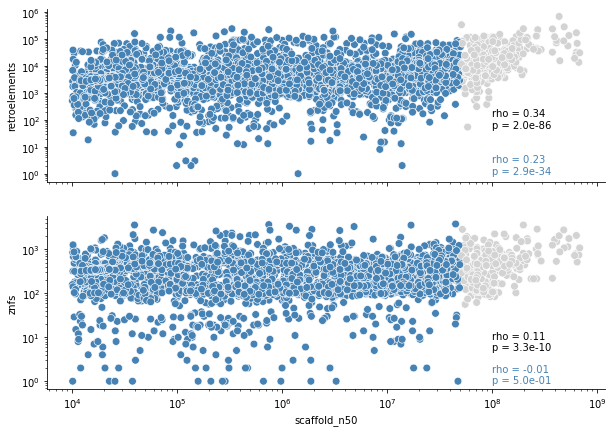

In [5]:
# qc_df = genus_df.loc[(genus_df.scaffold_n50 > 5e4) & (genus_df.scaffold_n50 < 5e8)]
qc_df = counts_df.copy()
n50max = 5e7
n50min = 1e4
qc_df['n50thresh'] = False
qc_df.loc[(qc_df.scaffold_n50 >= n50min) & (qc_df.scaffold_n50 < n50max), 'n50thresh'] = True

fig, axes = plt.subplots(figsize=(10, 7), 
                         nrows=2,
                         sharey=False,
                         sharex=True)

sns.scatterplot(data=qc_df, 
                x='scaffold_n50',
                y='retroelements', 
                s=60,
                hue='n50thresh',
                palette=['lightgrey', 'steelblue'],
                ax=axes[0])

sns.scatterplot(data=qc_df, 
                x='scaffold_n50',
                y='znfs', 
                s=60,
                hue='n50thresh',
                palette=['lightgrey', 'steelblue'],
                ax=axes[1])

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_yscale('log')


r1, p1 = stats.spearmanr(qc_df.retroelements, qc_df.scaffold_n50)
axes[0].text(x=10e7,
             y=50,
             s=f'rho = {r1:.2f}\np = {p1:.1e}')

r2, p2 = stats.spearmanr(qc_df.znfs, qc_df.scaffold_n50)
axes[1].text(x=10e7,
             y=5,
             s=f'rho = {r2:.2f}\np = {p2:.1e}')

r3, p3 = stats.spearmanr(qc_df.loc[qc_df.n50thresh == True, 'retroelements'], 
                         qc_df.loc[qc_df.n50thresh == True, 'scaffold_n50'])
axes[0].text(x=10e7,
             y=1,
             s=f'rho = {r3:.2f}\np = {p3:.1e}',
             c='steelblue')

r4, p4 = stats.spearmanr(qc_df.loc[qc_df.n50thresh == True, 'znfs'], 
                         qc_df.loc[qc_df.n50thresh == True, 'scaffold_n50'])
axes[1].text(x=10e7,
             y=0.9,
             s=f'rho = {r4:.2f}\np = {p4:.1e}',
             c='steelblue')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
sns.despine()
plt.show()

fig.savefig('../figs/scaffold_n50_qc.pdf')

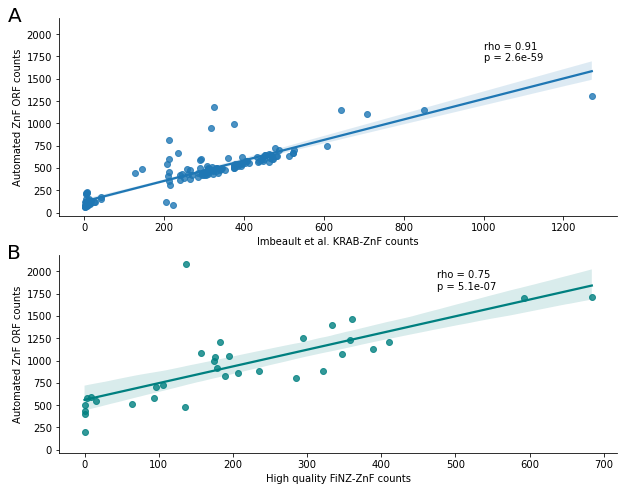

In [6]:
tetrapoda_qc_df = pd.read_csv('../data/Imbeault_supp_data_2.csv')
tetrapoda_qc_df = tetrapoda_qc_df.groupby('Latin name')['# of ZNFs'].count().reset_index()
tetrapoda_qc_df.columns = ['species', 'KRAB_znfs']
tetrapoda_qc_df['species'] = tetrapoda_qc_df.species.apply(lambda x: x.replace(' ', '_'))
tetrapoda_qc_df = tetrapoda_qc_df.merge(qc_df, on='species', how='inner')

cypriniform_qc_df = pd.read_csv('/Users/jonwells/Projects/feschottelab/finz-znf/data/finz_te_counts.txt', sep='\t') \
                      .merge(qc_df, on='species', how='inner')

fig, axes = plt.subplots(figsize=(10, 8), nrows=2, sharey=True)

sns.regplot(data=tetrapoda_qc_df, 
                x='KRAB_znfs', 
                y='znfs', 
                ax=axes[0])
axes[0].set_xlabel('Imbeault et al. KRAB-ZnF counts')
axes[0].set_ylabel('Automated ZnF ORF counts')
corr = stats.pearsonr(tetrapoda_qc_df.KRAB_znfs, tetrapoda_qc_df.znfs)
axes[0].text(x=1000, y=1700, s=f'rho = {corr[0]:.2f}\np = {corr[1]:.1e}')

sns.regplot(data=cypriniform_qc_df, 
                x='finz_znf', 
                y='znfs', 
                ax=axes[1],
                color='teal')
axes[1].set_xlabel('High quality FiNZ-ZnF counts')
axes[1].set_ylabel('Automated ZnF ORF counts')
corr = stats.pearsonr(cypriniform_qc_df.finz_znf, cypriniform_qc_df.znfs)
axes[1].text(x=475, y=1800, s=f'rho = {corr[0]:.2f}\np = {corr[1]:.1e}')

axes[0].text(x=-175, y=2200, s='A', fontsize=20, va='center', ha='center')
axes[1].text(x=-95, y=2200, s='B', fontsize=20, va='center', ha='center')
sns.despine()
plt.show()
fig.savefig('../figs/hiqual_pipeline_corr.pdf', bbox_inches='tight')

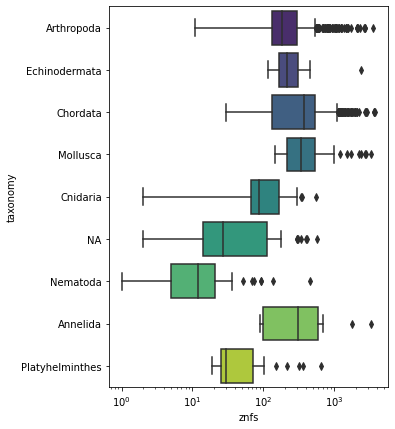

In [7]:
fig, ax = plt.subplots(figsize=(5, 7))
taxa = counts_df.groupby('taxonomy').count()
taxa = taxa.loc[taxa.species >= 10].reset_index()['taxonomy']
sns.boxplot(data=counts_df.loc[(counts_df.taxonomy.isin(taxa)) & (counts_df.scaffold_n50 > 5e4) & (counts_df.znfs > 0)], 
            x='znfs', 
            y='taxonomy',
            ax=ax,
            palette='viridis')
ax.set_xscale('log')

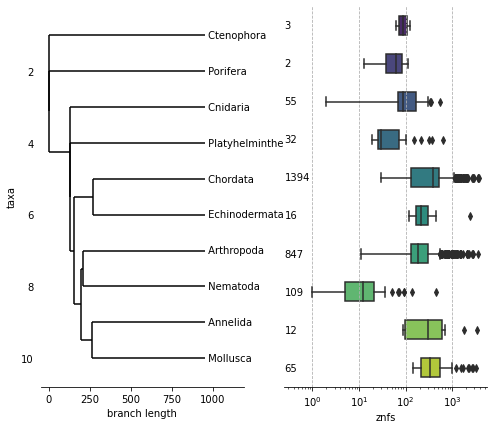

In [8]:
# taxlabels = {label: i for (i, label) in enumerate(target_taxa, 5)}
# counts_df['tax_label'] = counts_df.taxonomy.apply(taxlabels.get)
# counts_df['tax_label'] = pd.Categorical(counts_df.tax_label)
# print(counts_df.head())

fig, axes = plt.subplots(figsize=(8, 7), ncols=2, sharey=False)
sns.boxplot(data=counts_df.loc[(counts_df.scaffold_n50 > 5e4) & (counts_df.znfs > 0)],
            x='znfs', 
            y='taxonomy',
            hue_order=target_taxa,
            order=target_taxa,
            ax=axes[1],
            width=0.5,
            palette='viridis')

for i, tax in enumerate(target_taxa):
    n = len(counts_df.loc[(counts_df.scaffold_n50 > 5e4) & (counts_df.taxonomy == tax), 'species'])
    axes[1].text(0.25, i, n, va='center')

axes[1].set_ylabel('')
axes[1].set_yticklabels([])    
axes[1].set_xscale('log')
axes[1].set_xlim(0.25)
axes[1].tick_params(left=False)
axes[0].tick_params(left=False)
axes[1].grid(axis='x', which='major', linestyle='--')
sns.despine(left=True)

Phylo.draw(tree, axes=axes[0])

plt.show()
fig.savefig('/Users/jonwells/Desktop/test.pdf', bbox_inches='tight')

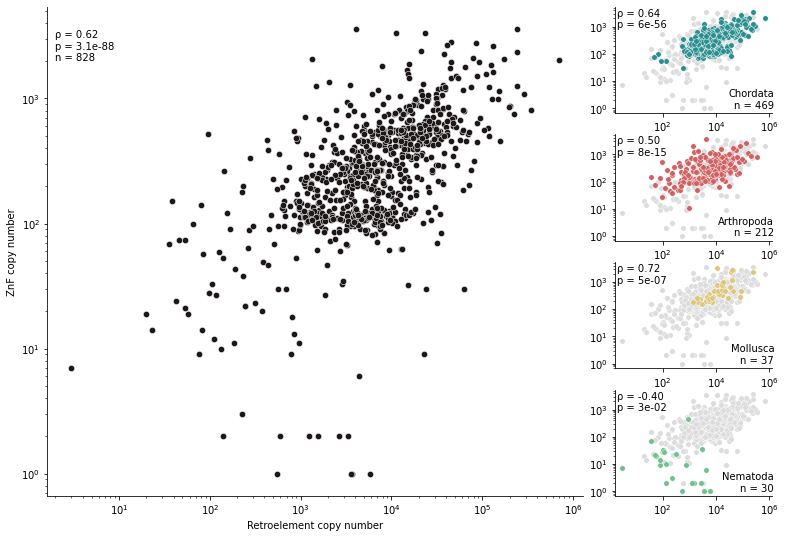

In [9]:
fig, ax = plt.subplots(figsize=(13, 9))
ax = plt.subplot2grid((4, 4), (0, 0), rowspan=5, colspan=3)
ax0 = plt.subplot2grid((4, 4), (0, 3), rowspan=1, colspan=1)
ax1 = plt.subplot2grid((4, 4), (1, 3), rowspan=1, colspan=1, sharex=ax0, sharey=ax0)
ax2 = plt.subplot2grid((4, 4), (2, 3), rowspan=1, colspan=1, sharex=ax1, sharey=ax1)
ax3 = plt.subplot2grid((4, 4), (3, 3), rowspan=1, colspan=1, sharex=ax2, sharey=ax2)

sns.scatterplot(data=family_df, 
                x='retroelements', 
                y='znfs', 
                color='#1D1718',
                s=40, 
                ax=ax)
corr = stats.spearmanr(family_df.znfs, family_df.retroelements)

ax.text(x=2, y=2000, s=f'ρ = {corr[0]:.2f}\np = {corr[1]:.1e}\nn = {len(family_df.znfs)}')
# ax.text(x=2, y=1600, s=f'p = {corr[1]:.1e}')

for axi, tax, colour in [(ax0, 'Chordata', '#2A8E90'), 
                         (ax1, 'Arthropoda', '#D06163'), 
                         (ax2, 'Mollusca', '#DDC77A'), 
                         (ax3, 'Nematoda', '#70C28C')]:

    sns.scatterplot(data=family_df.loc[family_df.taxonomy != tax], 
                x='retroelements', 
                y='znfs', 
                color='gainsboro',
                s=30, 
                ax=axi)
    sns.scatterplot(data=family_df.loc[family_df.taxonomy == tax], 
                x='retroelements', 
                y='znfs', 
                color = colour,
                s=30, 
                ax=axi)

    corr = stats.spearmanr(family_df.loc[family_df.taxonomy == tax, 'znfs'], 
                           family_df.loc[family_df.taxonomy == tax, 'retroelements'])
    axi.text(x=2, y=900, s=f'ρ = {corr[0]:.2f}\np = {corr[1]:.0e}')
    n = len(family_df.loc[family_df.taxonomy == tax, 'znfs'])
    axi.text(x=1500000, y=1, s=f'{tax}\nn = {n}', ha='right')
    axi.set_xscale('log')
    axi.set_yscale('log')
    axi.set_xlabel('')
    axi.set_ylabel('')    

ax.set_xlabel('Retroelement copy number')
ax.set_ylabel('ZnF copy number')
ax.set_xscale('log')
ax.set_yscale('log')
sns.despine()
plt.show()

fig.savefig('../figs/metazoan_znf_retroelement_correlation.pdf')

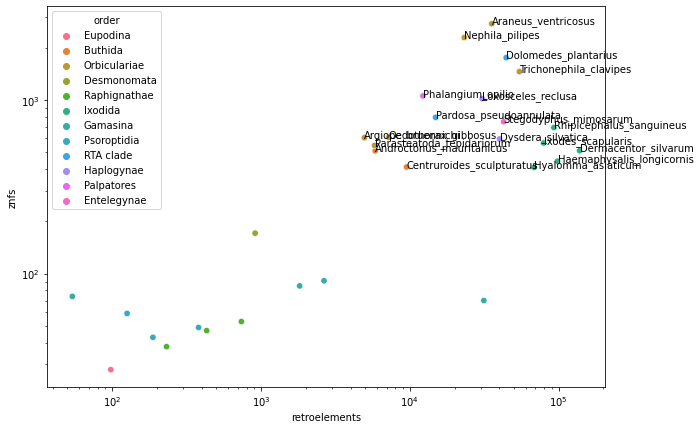

SpearmanrResult(correlation=0.8211462450592886, pvalue=1.5753241344652556e-06)


In [24]:
taxname = 'Arachnida'
taxgroup = {}
with open('../data/species_taxonomy.txt') as infile:
    for line in infile:
        line = [i.strip('\t').strip() for i in line.strip().split('|')][:-1]
        species = '_'.join(line[1].split(' '))
        lineage = [i.strip() for i in line[2].split(';')][:-1]
        taxgroup[species] = lineage
taxgroup = [key for key, val in taxgroup.items() if taxname in val]


fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=genus_df.loc[genus_df.species.isin(taxgroup)], 
                x='retroelements', 
                y='znfs', 
                hue='order',
                color='#1D1718',
                s=40, 
                ax=ax)

for i, row in genus_df.loc[(genus_df.species.isin(taxgroup)) & (genus_df.znfs >= 400) & (genus_df.retroelements >= 2000)].iterrows():
    ax.text(row.retroelements, row.znfs, row.species)

ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
# print(genus_df.loc[genus_df.species.isin(taxgroup), 'znfs'].median())
# print(genus_df.loc[(genus_df.taxonomy == 'Chordata') & ~(genus_df.species.isin(taxgroup)), 'znfs'].median())
print(stats.spearmanr(family_df.loc[family_df.species.isin(taxgroup), 'znfs'],
                      family_df.loc[family_df.species.isin(taxgroup), 'retroelements']))

In [18]:
print(family_df.loc[family_df.taxonomy == 'Arthropoda'][['species', 'order']].groupby('order').count().sort_values('species', ascending=False))

                 species
order                   
Obtectomera           18
Aculeata              13
Parasitoida           11
Cucujiformia          10
Ditrysia               8
...                  ...
Pantopoda              1
Caridea                1
Calanoida              1
Pisciforma             1
Hemerobiiformia        1

[89 rows x 1 columns]


Empty DataFrame
Columns: [species, znfs, retroelements, scaffold_n50, genus, family, order, taxonomy]
Index: []


<AxesSubplot:xlabel='retroelements', ylabel='znfs'>

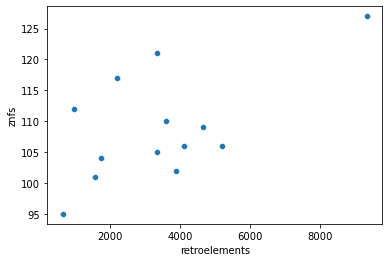

In [32]:
print(counts_df.loc[counts_df.species.str.startswith('Perin')])
sns.scatterplot(data=family_df.loc[family_df.order == 'Aculeata'], x='retroelements', y='znfs')

One possible explanation for the correlation between TEs and ZnFs is simply that high TE content in a genome facilitates higher duplication rates irrespective of gene family. In this case, we ought to see a broad correlation between TE and gene copy number across a range of large gene families. To do this, we tested olfactory receptors in mammals and protocadherins in molluscs.

In [73]:
or_df = pd.read_csv('../data/olfactory_receptor_ret_counts.txt', sep='\t').dropna()
or_df['genus'] = or_df['species'].apply(lambda x: x.split('_')[0])
or_df['family'] = or_df.species.apply(lambda x: famdict.get(x, 'Other'))
or_df['order'] = or_df.species.apply(lambda x: orderdict.get(x, 'Other'))
or_df['taxonomy'] = or_df.species.apply(lambda x: taxdict.get(x, 'Other'))
or_df = or_df.loc[or_df.taxonomy != 'Other']
or_df = or_df.sort_values('scaffold_n50').groupby('family').last().reset_index()
or_df = or_df.loc[(or_df.scaffold_n50 > 50000)]
print(or_df.head())

            family                species  olfactory_receptors  retroelements  \
0        Ailuridae        Ailurus_fulgens                 1124           8362   
1   Antilocapridae  Antilocapra_americana                 1319          66092   
2          Aotidae        Aotus_nancymaae                  598          13327   
3         Atelidae        Ateles_hybridus                  685          17251   
4  Balaenopteridae  Balaenoptera_musculus                  369          32755   

   scaffold_n50         genus        order  taxonomy  
0       2983736       Ailurus   Caniformia  Chordata  
1      18739554   Antilocapra       Pecora  Chordata  
2       8268663         Aotus  Platyrrhini  Chordata  
3      50515269        Ateles  Platyrrhini  Chordata  
4     110314666  Balaenoptera    Mysticeti  Chordata  


103


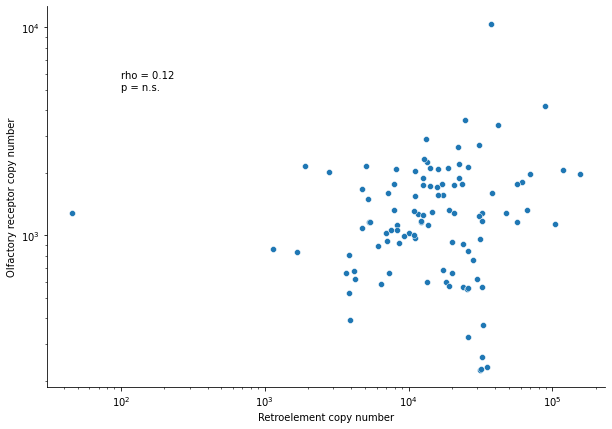

In [74]:
print(len(or_df))
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=or_df, 
                x='retroelements', 
                y='olfactory_receptors',
                ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')

rho, p = stats.spearmanr(or_df.retroelements, or_df.olfactory_receptors)
if p < 0.05:
    ax.text(s=f'rho = {rho:.2f}\np = {p:.2e}', x=1e2, y=5e3)
else:
    ax.text(s=f'rho = {rho:.2f}\np = n.s.', x=1e2, y=5e3)
    
ax.set_xlabel('Retroelement copy number')
ax.set_ylabel('Olfactory receptor copy number')

sns.despine()
plt.show()